<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[09:09:20] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


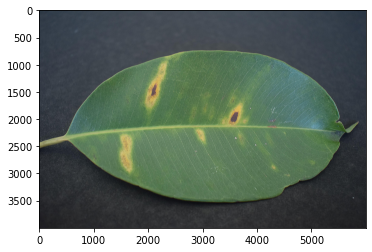

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

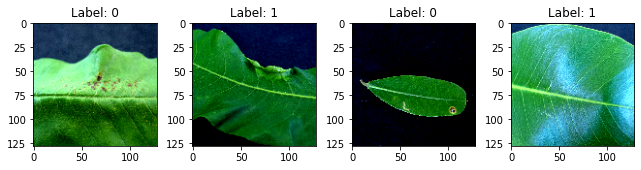

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[09:09:26] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[09:09:28] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2539127560904644 samples/sec                   batch loss = 0.9719051718711853 | accuracy = 0.45


Epoch[1] Batch[10] Speed: 1.2627697708385002 samples/sec                   batch loss = 0.5534992218017578 | accuracy = 0.5


Epoch[1] Batch[15] Speed: 1.2658722239278535 samples/sec                   batch loss = 0.6513828039169312 | accuracy = 0.5166666666666667


Epoch[1] Batch[20] Speed: 1.2603185799757135 samples/sec                   batch loss = 0.5876742005348206 | accuracy = 0.5125


Epoch[1] Batch[25] Speed: 1.2576609546540989 samples/sec                   batch loss = 0.31123337149620056 | accuracy = 0.5


Epoch[1] Batch[30] Speed: 1.2592960552873165 samples/sec                   batch loss = 0.5755824446678162 | accuracy = 0.525


Epoch[1] Batch[35] Speed: 1.2595865903391696 samples/sec                   batch loss = 1.3150146007537842 | accuracy = 0.55


Epoch[1] Batch[40] Speed: 1.2621239865693141 samples/sec                   batch loss = 0.7890534400939941 | accuracy = 0.55625


Epoch[1] Batch[45] Speed: 1.2622819042402555 samples/sec                   batch loss = 1.4174108505249023 | accuracy = 0.5666666666666667


Epoch[1] Batch[50] Speed: 1.2615396646364387 samples/sec                   batch loss = 0.7577313780784607 | accuracy = 0.585


Epoch[1] Batch[55] Speed: 1.2576314465431435 samples/sec                   batch loss = 0.31312882900238037 | accuracy = 0.5954545454545455


Epoch[1] Batch[60] Speed: 1.261252779182117 samples/sec                   batch loss = 0.7001952528953552 | accuracy = 0.5833333333333334


Epoch[1] Batch[65] Speed: 1.2563484769413935 samples/sec                   batch loss = 0.6831490397453308 | accuracy = 0.5846153846153846


Epoch[1] Batch[70] Speed: 1.2649429022514895 samples/sec                   batch loss = 0.7052331566810608 | accuracy = 0.5892857142857143


Epoch[1] Batch[75] Speed: 1.2612318250617227 samples/sec                   batch loss = 0.41094970703125 | accuracy = 0.6


Epoch[1] Batch[80] Speed: 1.2608407460726334 samples/sec                   batch loss = 1.0186192989349365 | accuracy = 0.59375


Epoch[1] Batch[85] Speed: 1.260368286936872 samples/sec                   batch loss = 0.6573338508605957 | accuracy = 0.6058823529411764


Epoch[1] Batch[90] Speed: 1.2569724473568555 samples/sec                   batch loss = 0.31294912099838257 | accuracy = 0.6111111111111112


Epoch[1] Batch[95] Speed: 1.2634110786403592 samples/sec                   batch loss = 0.4642588496208191 | accuracy = 0.6236842105263158


Epoch[1] Batch[100] Speed: 1.2619092515628871 samples/sec                   batch loss = 0.9445013403892517 | accuracy = 0.625


Epoch[1] Batch[105] Speed: 1.2563310722610583 samples/sec                   batch loss = 0.3909427225589752 | accuracy = 0.6261904761904762


Epoch[1] Batch[110] Speed: 1.2650533529401387 samples/sec                   batch loss = 0.4704727232456207 | accuracy = 0.634090909090909


Epoch[1] Batch[115] Speed: 1.2619427575632851 samples/sec                   batch loss = 0.6651361584663391 | accuracy = 0.6347826086956522


Epoch[1] Batch[120] Speed: 1.2589068369159229 samples/sec                   batch loss = 1.1205928325653076 | accuracy = 0.6395833333333333


Epoch[1] Batch[125] Speed: 1.259399376996804 samples/sec                   batch loss = 0.7662060856819153 | accuracy = 0.642


Epoch[1] Batch[130] Speed: 1.2567361147316312 samples/sec                   batch loss = 0.4100877344608307 | accuracy = 0.6423076923076924


Epoch[1] Batch[135] Speed: 1.2521040218836634 samples/sec                   batch loss = 0.3239709734916687 | accuracy = 0.6444444444444445


Epoch[1] Batch[140] Speed: 1.2560020734210864 samples/sec                   batch loss = 0.600004255771637 | accuracy = 0.6482142857142857


Epoch[1] Batch[145] Speed: 1.2485561453072322 samples/sec                   batch loss = 0.3892712891101837 | accuracy = 0.65


Epoch[1] Batch[150] Speed: 1.2297080805740508 samples/sec                   batch loss = 1.1922043561935425 | accuracy = 0.65


Epoch[1] Batch[155] Speed: 1.2593075871535917 samples/sec                   batch loss = 0.44601354002952576 | accuracy = 0.646774193548387


Epoch[1] Batch[160] Speed: 1.264607567030235 samples/sec                   batch loss = 0.725254237651825 | accuracy = 0.6421875


Epoch[1] Batch[165] Speed: 1.262477575640825 samples/sec                   batch loss = 0.8017584681510925 | accuracy = 0.6424242424242425


Epoch[1] Batch[170] Speed: 1.2611241261808463 samples/sec                   batch loss = 0.6510767936706543 | accuracy = 0.6426470588235295


Epoch[1] Batch[175] Speed: 1.2699026501241086 samples/sec                   batch loss = 0.3756318688392639 | accuracy = 0.6414285714285715


Epoch[1] Batch[180] Speed: 1.2637743377190618 samples/sec                   batch loss = 0.21505726873874664 | accuracy = 0.6458333333333334


Epoch[1] Batch[185] Speed: 1.2619902195324717 samples/sec                   batch loss = 0.7106373310089111 | accuracy = 0.6432432432432432


Epoch[1] Batch[190] Speed: 1.2606303310951052 samples/sec                   batch loss = 0.5350366830825806 | accuracy = 0.6421052631578947


Epoch[1] Batch[195] Speed: 1.2644133312984809 samples/sec                   batch loss = 0.5799646377563477 | accuracy = 0.6423076923076924


Epoch[1] Batch[200] Speed: 1.2565574648378899 samples/sec                   batch loss = 0.5188957452774048 | accuracy = 0.645


Epoch[1] Batch[205] Speed: 1.2565808991526857 samples/sec                   batch loss = 0.382520854473114 | accuracy = 0.6463414634146342


Epoch[1] Batch[210] Speed: 1.2578001233868268 samples/sec                   batch loss = 0.7897310853004456 | accuracy = 0.6464285714285715


Epoch[1] Batch[215] Speed: 1.261964399778435 samples/sec                   batch loss = 0.7988691926002502 | accuracy = 0.6511627906976745


Epoch[1] Batch[220] Speed: 1.2656732073399803 samples/sec                   batch loss = 0.5855399966239929 | accuracy = 0.6488636363636363


Epoch[1] Batch[225] Speed: 1.2583258668776325 samples/sec                   batch loss = 0.5906971096992493 | accuracy = 0.6455555555555555


Epoch[1] Batch[230] Speed: 1.2591009908022344 samples/sec                   batch loss = 0.18848277628421783 | accuracy = 0.6478260869565218


Epoch[1] Batch[235] Speed: 1.2656988926239154 samples/sec                   batch loss = 0.381578266620636 | accuracy = 0.6531914893617021


Epoch[1] Batch[240] Speed: 1.2590988174589886 samples/sec                   batch loss = 0.895241379737854 | accuracy = 0.653125


Epoch[1] Batch[245] Speed: 1.2593982425401489 samples/sec                   batch loss = 0.7723847031593323 | accuracy = 0.6551020408163265


Epoch[1] Batch[250] Speed: 1.255372020671731 samples/sec                   batch loss = 0.2504733204841614 | accuracy = 0.661


Epoch[1] Batch[255] Speed: 1.2529844350223498 samples/sec                   batch loss = 0.774365246295929 | accuracy = 0.6607843137254902


Epoch[1] Batch[260] Speed: 1.2566701269529839 samples/sec                   batch loss = 0.43930575251579285 | accuracy = 0.6634615384615384


Epoch[1] Batch[265] Speed: 1.2544338472804588 samples/sec                   batch loss = 0.2773745656013489 | accuracy = 0.6669811320754717


Epoch[1] Batch[270] Speed: 1.2523195455550096 samples/sec                   batch loss = 1.226776123046875 | accuracy = 0.6638888888888889


Epoch[1] Batch[275] Speed: 1.2552463489313972 samples/sec                   batch loss = 0.10817644745111465 | accuracy = 0.6636363636363637


Epoch[1] Batch[280] Speed: 1.2568510686242935 samples/sec                   batch loss = 0.30100196599960327 | accuracy = 0.6678571428571428


Epoch[1] Batch[285] Speed: 1.261854867423835 samples/sec                   batch loss = 0.6535720825195312 | accuracy = 0.6666666666666666


Epoch[1] Batch[290] Speed: 1.2584556486918927 samples/sec                   batch loss = 0.19582870602607727 | accuracy = 0.6698275862068965


Epoch[1] Batch[295] Speed: 1.2584955796821404 samples/sec                   batch loss = 0.09412218630313873 | accuracy = 0.6694915254237288


Epoch[1] Batch[300] Speed: 1.258071383477522 samples/sec                   batch loss = 0.09215496480464935 | accuracy = 0.6725


Epoch[1] Batch[305] Speed: 1.259020298654951 samples/sec                   batch loss = 0.3563995659351349 | accuracy = 0.6737704918032786


Epoch[1] Batch[310] Speed: 1.2617240040408941 samples/sec                   batch loss = 0.1373794823884964 | accuracy = 0.6758064516129032


Epoch[1] Batch[315] Speed: 1.2634940473756346 samples/sec                   batch loss = 0.4310011565685272 | accuracy = 0.6753968253968254


Epoch[1] Batch[320] Speed: 1.2658963890312023 samples/sec                   batch loss = 0.7003390192985535 | accuracy = 0.6765625


Epoch[1] Batch[325] Speed: 1.2663492971651864 samples/sec                   batch loss = 0.3272598683834076 | accuracy = 0.676923076923077


Epoch[1] Batch[330] Speed: 1.2599675237920291 samples/sec                   batch loss = 0.17752160131931305 | accuracy = 0.6787878787878788


Epoch[1] Batch[335] Speed: 1.263147687069862 samples/sec                   batch loss = 0.16421979665756226 | accuracy = 0.6805970149253732


Epoch[1] Batch[340] Speed: 1.2601252808431351 samples/sec                   batch loss = 0.652940034866333 | accuracy = 0.6808823529411765


Epoch[1] Batch[345] Speed: 1.2619502563169473 samples/sec                   batch loss = 0.30704954266548157 | accuracy = 0.6804347826086956


Epoch[1] Batch[350] Speed: 1.2737929416516653 samples/sec                   batch loss = 0.9321061968803406 | accuracy = 0.6821428571428572


Epoch[1] Batch[355] Speed: 1.272506336472071 samples/sec                   batch loss = 0.3750849664211273 | accuracy = 0.680281690140845


Epoch[1] Batch[360] Speed: 1.2607491249753238 samples/sec                   batch loss = 0.5487164855003357 | accuracy = 0.6798611111111111


Epoch[1] Batch[365] Speed: 1.2699797443223129 samples/sec                   batch loss = 0.5859124660491943 | accuracy = 0.6801369863013699


Epoch[1] Batch[370] Speed: 1.26491820132561 samples/sec                   batch loss = 0.40676525235176086 | accuracy = 0.6797297297297298


Epoch[1] Batch[375] Speed: 1.265466139920119 samples/sec                   batch loss = 0.2580775022506714 | accuracy = 0.6806666666666666


Epoch[1] Batch[380] Speed: 1.267821285823406 samples/sec                   batch loss = 0.36400341987609863 | accuracy = 0.6782894736842106


Epoch[1] Batch[385] Speed: 1.2659225609743214 samples/sec                   batch loss = 0.5372607707977295 | accuracy = 0.6792207792207792


Epoch[1] Batch[390] Speed: 1.2676191657742244 samples/sec                   batch loss = 0.8714098930358887 | accuracy = 0.6788461538461539


Epoch[1] Batch[395] Speed: 1.2757556247308626 samples/sec                   batch loss = 0.5353198647499084 | accuracy = 0.6791139240506329


Epoch[1] Batch[400] Speed: 1.274412776505348 samples/sec                   batch loss = 0.414468377828598 | accuracy = 0.67875


Epoch[1] Batch[405] Speed: 1.2692971806561812 samples/sec                   batch loss = 0.6004146337509155 | accuracy = 0.6771604938271605


Epoch[1] Batch[410] Speed: 1.2686550652426032 samples/sec                   batch loss = 1.1118807792663574 | accuracy = 0.676219512195122


Epoch[1] Batch[415] Speed: 1.266028597072438 samples/sec                   batch loss = 0.2475425899028778 | accuracy = 0.6759036144578313


Epoch[1] Batch[420] Speed: 1.2741863885046583 samples/sec                   batch loss = 0.6226723790168762 | accuracy = 0.6779761904761905


Epoch[1] Batch[425] Speed: 1.2760578814897703 samples/sec                   batch loss = 0.7994626760482788 | accuracy = 0.678235294117647


Epoch[1] Batch[430] Speed: 1.2671024722038968 samples/sec                   batch loss = 0.37877142429351807 | accuracy = 0.6784883720930233


Epoch[1] Batch[435] Speed: 1.2580873269486679 samples/sec                   batch loss = 0.7009854316711426 | accuracy = 0.6781609195402298


Epoch[1] Batch[440] Speed: 1.2642708852193663 samples/sec                   batch loss = 0.7008998394012451 | accuracy = 0.6772727272727272


Epoch[1] Batch[445] Speed: 1.2695965766359703 samples/sec                   batch loss = 0.4291910231113434 | accuracy = 0.6786516853932584


Epoch[1] Batch[450] Speed: 1.2693083202289674 samples/sec                   batch loss = 1.0577976703643799 | accuracy = 0.6794444444444444


Epoch[1] Batch[455] Speed: 1.2652164889740483 samples/sec                   batch loss = 0.6518725156784058 | accuracy = 0.6807692307692308


Epoch[1] Batch[460] Speed: 1.2657215232732615 samples/sec                   batch loss = 0.46296271681785583 | accuracy = 0.6826086956521739


Epoch[1] Batch[465] Speed: 1.2622225499095119 samples/sec                   batch loss = 0.914354681968689 | accuracy = 0.6811827956989247


Epoch[1] Batch[470] Speed: 1.2667717300238175 samples/sec                   batch loss = 0.7709184288978577 | accuracy = 0.6781914893617021


Epoch[1] Batch[475] Speed: 1.2670398886994894 samples/sec                   batch loss = 0.21949993073940277 | accuracy = 0.6794736842105263


Epoch[1] Batch[480] Speed: 1.2659242803369335 samples/sec                   batch loss = 0.691651463508606 | accuracy = 0.6796875


Epoch[1] Batch[485] Speed: 1.2747118790874192 samples/sec                   batch loss = 0.9260302186012268 | accuracy = 0.6814432989690722


Epoch[1] Batch[490] Speed: 1.273184530684589 samples/sec                   batch loss = 0.2524380087852478 | accuracy = 0.6836734693877551


Epoch[1] Batch[495] Speed: 1.2741311345582718 samples/sec                   batch loss = 0.9047580361366272 | accuracy = 0.6828282828282828


Epoch[1] Batch[500] Speed: 1.2686800082666934 samples/sec                   batch loss = 0.8003522157669067 | accuracy = 0.683


Epoch[1] Batch[505] Speed: 1.2685340095736526 samples/sec                   batch loss = 0.2767024040222168 | accuracy = 0.6826732673267327


Epoch[1] Batch[510] Speed: 1.277394377435675 samples/sec                   batch loss = 1.0376838445663452 | accuracy = 0.6833333333333333


Epoch[1] Batch[515] Speed: 1.2710425210031446 samples/sec                   batch loss = 0.3195831775665283 | accuracy = 0.6854368932038835


Epoch[1] Batch[520] Speed: 1.2744960347328174 samples/sec                   batch loss = 1.170078158378601 | accuracy = 0.6850961538461539


Epoch[1] Batch[525] Speed: 1.2654420866876632 samples/sec                   batch loss = 0.3928382694721222 | accuracy = 0.6861904761904762


Epoch[1] Batch[530] Speed: 1.2612820781920167 samples/sec                   batch loss = 0.6843925714492798 | accuracy = 0.6839622641509434


Epoch[1] Batch[535] Speed: 1.2703389036110113 samples/sec                   batch loss = 0.6153231263160706 | accuracy = 0.6836448598130841


Epoch[1] Batch[540] Speed: 1.2704056613460295 samples/sec                   batch loss = 0.8871240615844727 | accuracy = 0.6837962962962963


Epoch[1] Batch[545] Speed: 1.2699431186046657 samples/sec                   batch loss = 0.37998124957084656 | accuracy = 0.6862385321100918


Epoch[1] Batch[550] Speed: 1.2639086736979674 samples/sec                   batch loss = 0.4446093738079071 | accuracy = 0.6868181818181818


Epoch[1] Batch[555] Speed: 1.271290141698871 samples/sec                   batch loss = 0.433938592672348 | accuracy = 0.6869369369369369


Epoch[1] Batch[560] Speed: 1.2695632393945313 samples/sec                   batch loss = 0.5982613563537598 | accuracy = 0.6852678571428571


Epoch[1] Batch[565] Speed: 1.2727069286571875 samples/sec                   batch loss = 0.6492567658424377 | accuracy = 0.6849557522123894


Epoch[1] Batch[570] Speed: 1.2687863149200982 samples/sec                   batch loss = 0.27812615036964417 | accuracy = 0.6850877192982456


Epoch[1] Batch[575] Speed: 1.2704111446418334 samples/sec                   batch loss = 0.6565083861351013 | accuracy = 0.6852173913043478


Epoch[1] Batch[580] Speed: 1.2643263353290597 samples/sec                   batch loss = 0.3257580101490021 | accuracy = 0.6853448275862069


Epoch[1] Batch[585] Speed: 1.2641834325608228 samples/sec                   batch loss = 0.2950400114059448 | accuracy = 0.6854700854700855


Epoch[1] Batch[590] Speed: 1.2669120614863918 samples/sec                   batch loss = 0.32668182253837585 | accuracy = 0.686864406779661


Epoch[1] Batch[595] Speed: 1.2642468774024112 samples/sec                   batch loss = 0.352601021528244 | accuracy = 0.6873949579831933


Epoch[1] Batch[600] Speed: 1.2621155362865017 samples/sec                   batch loss = 0.6249949932098389 | accuracy = 0.6883333333333334


Epoch[1] Batch[605] Speed: 1.2674768582873803 samples/sec                   batch loss = 0.5120080709457397 | accuracy = 0.6888429752066115


Epoch[1] Batch[610] Speed: 1.2643177602519047 samples/sec                   batch loss = 0.5514097809791565 | accuracy = 0.6889344262295082


Epoch[1] Batch[615] Speed: 1.2708963631712504 samples/sec                   batch loss = 0.8002709746360779 | accuracy = 0.6890243902439024


Epoch[1] Batch[620] Speed: 1.2614515460947198 samples/sec                   batch loss = 0.31579723954200745 | accuracy = 0.6899193548387097


Epoch[1] Batch[625] Speed: 1.2666729331326554 samples/sec                   batch loss = 0.43708720803260803 | accuracy = 0.6896


Epoch[1] Batch[630] Speed: 1.2680937229904314 samples/sec                   batch loss = 0.8334763646125793 | accuracy = 0.6892857142857143


Epoch[1] Batch[635] Speed: 1.2716783808590195 samples/sec                   batch loss = 1.4034334421157837 | accuracy = 0.6889763779527559


Epoch[1] Batch[640] Speed: 1.2615650875587237 samples/sec                   batch loss = 0.7439208626747131 | accuracy = 0.68828125


Epoch[1] Batch[645] Speed: 1.2613479822338451 samples/sec                   batch loss = 0.4126946032047272 | accuracy = 0.6891472868217055


Epoch[1] Batch[650] Speed: 1.26485144689317 samples/sec                   batch loss = 0.4819207489490509 | accuracy = 0.6892307692307692


Epoch[1] Batch[655] Speed: 1.2638598296022188 samples/sec                   batch loss = 0.36351609230041504 | accuracy = 0.6904580152671755


Epoch[1] Batch[660] Speed: 1.2711006853793938 samples/sec                   batch loss = 0.36606302857398987 | accuracy = 0.6912878787878788


Epoch[1] Batch[665] Speed: 1.265524176880543 samples/sec                   batch loss = 0.40447288751602173 | accuracy = 0.6913533834586466


Epoch[1] Batch[670] Speed: 1.2599734850979656 samples/sec                   batch loss = 0.4978075623512268 | accuracy = 0.6902985074626866


Epoch[1] Batch[675] Speed: 1.2686530506565423 samples/sec                   batch loss = 0.5979300737380981 | accuracy = 0.6896296296296296


Epoch[1] Batch[680] Speed: 1.2659949692873589 samples/sec                   batch loss = 0.21586818993091583 | accuracy = 0.6908088235294118


Epoch[1] Batch[685] Speed: 1.2648282752162137 samples/sec                   batch loss = 0.5089103579521179 | accuracy = 0.6905109489051094


Epoch[1] Batch[690] Speed: 1.26700888631753 samples/sec                   batch loss = 0.3023560047149658 | accuracy = 0.6898550724637681


Epoch[1] Batch[695] Speed: 1.257614666190323 samples/sec                   batch loss = 0.31676897406578064 | accuracy = 0.6906474820143885


Epoch[1] Batch[700] Speed: 1.261054264472529 samples/sec                   batch loss = 0.7445022463798523 | accuracy = 0.69


Epoch[1] Batch[705] Speed: 1.2592127863580158 samples/sec                   batch loss = 0.46252065896987915 | accuracy = 0.6900709219858157


Epoch[1] Batch[710] Speed: 1.2658741341791198 samples/sec                   batch loss = 0.4509110450744629 | accuracy = 0.6908450704225352


Epoch[1] Batch[715] Speed: 1.2621111687689546 samples/sec                   batch loss = 0.6575186848640442 | accuracy = 0.6909090909090909


Epoch[1] Batch[720] Speed: 1.2615474431829716 samples/sec                   batch loss = 0.27179402112960815 | accuracy = 0.6920138888888889


Epoch[1] Batch[725] Speed: 1.26110156483724 samples/sec                   batch loss = 0.43639978766441345 | accuracy = 0.6920689655172414


Epoch[1] Batch[730] Speed: 1.2648038648205406 samples/sec                   batch loss = 0.38923180103302 | accuracy = 0.6924657534246575


Epoch[1] Batch[735] Speed: 1.267370196508216 samples/sec                   batch loss = 0.2692998945713043 | accuracy = 0.6931972789115646


Epoch[1] Batch[740] Speed: 1.2629239523613482 samples/sec                   batch loss = 0.23141887784004211 | accuracy = 0.6942567567567568


Epoch[1] Batch[745] Speed: 1.264963789115299 samples/sec                   batch loss = 0.7702193260192871 | accuracy = 0.6946308724832215


Epoch[1] Batch[750] Speed: 1.266570900634538 samples/sec                   batch loss = 0.2152767926454544 | accuracy = 0.6943333333333334


Epoch[1] Batch[755] Speed: 1.2682884200566757 samples/sec                   batch loss = 0.593822181224823 | accuracy = 0.6937086092715232


Epoch[1] Batch[760] Speed: 1.2639519986186132 samples/sec                   batch loss = 1.2356075048446655 | accuracy = 0.6927631578947369


Epoch[1] Batch[765] Speed: 1.2643917002951692 samples/sec                   batch loss = 1.6268103122711182 | accuracy = 0.692156862745098


Epoch[1] Batch[770] Speed: 1.2650539252737283 samples/sec                   batch loss = 0.43757182359695435 | accuracy = 0.6918831168831169


Epoch[1] Batch[775] Speed: 1.26809631089025 samples/sec                   batch loss = 0.32981789112091064 | accuracy = 0.692258064516129


Epoch[1] Batch[780] Speed: 1.261541372114046 samples/sec                   batch loss = 0.49793899059295654 | accuracy = 0.6932692307692307


Epoch[1] Batch[785] Speed: 1.2888478492335538 samples/sec                   batch loss = 0.3130795359611511 | accuracy = 0.6942675159235668


[Epoch 1] training: accuracy=0.694479695431472
[Epoch 1] time cost: 647.8514978885651
[Epoch 1] validation: validation accuracy=0.7644444444444445


Epoch[2] Batch[5] Speed: 1.2887113275399296 samples/sec                   batch loss = 0.36435872316360474 | accuracy = 0.65


Epoch[2] Batch[10] Speed: 1.292288134718514 samples/sec                   batch loss = 0.3977366089820862 | accuracy = 0.675


Epoch[2] Batch[15] Speed: 1.2909336183810207 samples/sec                   batch loss = 0.48879551887512207 | accuracy = 0.75


Epoch[2] Batch[20] Speed: 1.2956212550197244 samples/sec                   batch loss = 0.36421722173690796 | accuracy = 0.7625


Epoch[2] Batch[25] Speed: 1.2974469153300927 samples/sec                   batch loss = 0.5390876531600952 | accuracy = 0.76


Epoch[2] Batch[30] Speed: 1.2929782175626523 samples/sec                   batch loss = 0.6305519938468933 | accuracy = 0.7583333333333333


Epoch[2] Batch[35] Speed: 1.2967367206192473 samples/sec                   batch loss = 0.40310138463974 | accuracy = 0.7428571428571429


Epoch[2] Batch[40] Speed: 1.2969310894506059 samples/sec                   batch loss = 0.2672588527202606 | accuracy = 0.73125


Epoch[2] Batch[45] Speed: 1.2940514047338363 samples/sec                   batch loss = 1.5099406242370605 | accuracy = 0.7333333333333333


Epoch[2] Batch[50] Speed: 1.2971195996600953 samples/sec                   batch loss = 0.11121944338083267 | accuracy = 0.74


Epoch[2] Batch[55] Speed: 1.2927499674832532 samples/sec                   batch loss = 0.3574172556400299 | accuracy = 0.7454545454545455


Epoch[2] Batch[60] Speed: 1.2911828897727888 samples/sec                   batch loss = 0.188103586435318 | accuracy = 0.7458333333333333


Epoch[2] Batch[65] Speed: 1.293804017858692 samples/sec                   batch loss = 0.2303560972213745 | accuracy = 0.75


Epoch[2] Batch[70] Speed: 1.2948908695894121 samples/sec                   batch loss = 0.9543264508247375 | accuracy = 0.7428571428571429


Epoch[2] Batch[75] Speed: 1.2904444957562868 samples/sec                   batch loss = 0.8159313201904297 | accuracy = 0.7433333333333333


Epoch[2] Batch[80] Speed: 1.2961037969782327 samples/sec                   batch loss = 0.4736725986003876 | accuracy = 0.73125


Epoch[2] Batch[85] Speed: 1.2965426104320994 samples/sec                   batch loss = 0.285165399312973 | accuracy = 0.7352941176470589


Epoch[2] Batch[90] Speed: 1.2948866720544332 samples/sec                   batch loss = 0.36457085609436035 | accuracy = 0.7444444444444445


Epoch[2] Batch[95] Speed: 1.3005995068685066 samples/sec                   batch loss = 0.40178126096725464 | accuracy = 0.7421052631578947


Epoch[2] Batch[100] Speed: 1.299705201496257 samples/sec                   batch loss = 0.13300329446792603 | accuracy = 0.74


Epoch[2] Batch[105] Speed: 1.2951625679445948 samples/sec                   batch loss = 0.5516760349273682 | accuracy = 0.7428571428571429


Epoch[2] Batch[110] Speed: 1.2935948257489984 samples/sec                   batch loss = 0.13914728164672852 | accuracy = 0.7545454545454545


Epoch[2] Batch[115] Speed: 1.2962958727682317 samples/sec                   batch loss = 0.48822855949401855 | accuracy = 0.7543478260869565


Epoch[2] Batch[120] Speed: 1.2968438718867394 samples/sec                   batch loss = 0.5383800864219666 | accuracy = 0.7541666666666667


Epoch[2] Batch[125] Speed: 1.2984479424427424 samples/sec                   batch loss = 0.39303553104400635 | accuracy = 0.756


Epoch[2] Batch[130] Speed: 1.2912486761157935 samples/sec                   batch loss = 0.3506125211715698 | accuracy = 0.7480769230769231


Epoch[2] Batch[135] Speed: 1.2972596139757067 samples/sec                   batch loss = 0.4841383695602417 | accuracy = 0.75


Epoch[2] Batch[140] Speed: 1.2955894384989055 samples/sec                   batch loss = 0.211726576089859 | accuracy = 0.7535714285714286


Epoch[2] Batch[145] Speed: 1.3010670985871542 samples/sec                   batch loss = 0.8418900966644287 | accuracy = 0.756896551724138


Epoch[2] Batch[150] Speed: 1.2931599985293452 samples/sec                   batch loss = 0.3510470986366272 | accuracy = 0.7583333333333333


Epoch[2] Batch[155] Speed: 1.2939743543862983 samples/sec                   batch loss = 0.5932042598724365 | accuracy = 0.7564516129032258


Epoch[2] Batch[160] Speed: 1.2999233243392845 samples/sec                   batch loss = 0.7062187790870667 | accuracy = 0.759375


Epoch[2] Batch[165] Speed: 1.300690255500127 samples/sec                   batch loss = 0.09273319691419601 | accuracy = 0.759090909090909


Epoch[2] Batch[170] Speed: 1.3002410727668374 samples/sec                   batch loss = 0.32473623752593994 | accuracy = 0.7602941176470588


Epoch[2] Batch[175] Speed: 1.2967575681219865 samples/sec                   batch loss = 0.31958022713661194 | accuracy = 0.7642857142857142


Epoch[2] Batch[180] Speed: 1.2975123380798612 samples/sec                   batch loss = 0.054018497467041016 | accuracy = 0.7666666666666667


Epoch[2] Batch[185] Speed: 1.2959957668442712 samples/sec                   batch loss = 0.31335946917533875 | accuracy = 0.7675675675675676


Epoch[2] Batch[190] Speed: 1.299862190194267 samples/sec                   batch loss = 0.26267534494400024 | accuracy = 0.7684210526315789


Epoch[2] Batch[195] Speed: 1.2971785704869503 samples/sec                   batch loss = 0.3590945899486542 | accuracy = 0.767948717948718


Epoch[2] Batch[200] Speed: 1.2986691618462927 samples/sec                   batch loss = 0.5739838480949402 | accuracy = 0.76875


Epoch[2] Batch[205] Speed: 1.2962926676999582 samples/sec                   batch loss = 0.3926813006401062 | accuracy = 0.7682926829268293


Epoch[2] Batch[210] Speed: 1.294895366978517 samples/sec                   batch loss = 0.4579964578151703 | accuracy = 0.7690476190476191


Epoch[2] Batch[215] Speed: 1.2975734520987943 samples/sec                   batch loss = 0.7751675844192505 | accuracy = 0.7697674418604651


Epoch[2] Batch[220] Speed: 1.2992987578873088 samples/sec                   batch loss = 1.0107991695404053 | accuracy = 0.7727272727272727


Epoch[2] Batch[225] Speed: 1.29593780443757 samples/sec                   batch loss = 0.3343975841999054 | accuracy = 0.7733333333333333


Epoch[2] Batch[230] Speed: 1.2929157421581434 samples/sec                   batch loss = 1.729742407798767 | accuracy = 0.7739130434782608


Epoch[2] Batch[235] Speed: 1.2888380472200152 samples/sec                   batch loss = 0.9439587593078613 | accuracy = 0.774468085106383


Epoch[2] Batch[240] Speed: 1.2991565928541189 samples/sec                   batch loss = 0.27718159556388855 | accuracy = 0.778125


Epoch[2] Batch[245] Speed: 1.2921956684236409 samples/sec                   batch loss = 0.21587619185447693 | accuracy = 0.7816326530612245


Epoch[2] Batch[250] Speed: 1.3003587818623328 samples/sec                   batch loss = 0.5753198266029358 | accuracy = 0.781


Epoch[2] Batch[255] Speed: 1.3016445881818524 samples/sec                   batch loss = 0.4453864097595215 | accuracy = 0.7784313725490196


Epoch[2] Batch[260] Speed: 1.2975468582631797 samples/sec                   batch loss = 0.36649248003959656 | accuracy = 0.7798076923076923


Epoch[2] Batch[265] Speed: 1.300038961147646 samples/sec                   batch loss = 0.5116559267044067 | accuracy = 0.7820754716981132


Epoch[2] Batch[270] Speed: 1.298475176201672 samples/sec                   batch loss = 0.5598387718200684 | accuracy = 0.7805555555555556


Epoch[2] Batch[275] Speed: 1.2905897242933675 samples/sec                   batch loss = 0.17880649864673615 | accuracy = 0.7790909090909091


Epoch[2] Batch[280] Speed: 1.291144832154872 samples/sec                   batch loss = 0.6467550992965698 | accuracy = 0.7803571428571429


Epoch[2] Batch[285] Speed: 1.2910647495611345 samples/sec                   batch loss = 0.4296824038028717 | accuracy = 0.7798245614035088


Epoch[2] Batch[290] Speed: 1.2997061076724126 samples/sec                   batch loss = 0.2401348054409027 | accuracy = 0.781896551724138


Epoch[2] Batch[295] Speed: 1.2968744468237305 samples/sec                   batch loss = 0.6985099911689758 | accuracy = 0.7771186440677966


Epoch[2] Batch[300] Speed: 1.3024648151932037 samples/sec                   batch loss = 0.36612647771835327 | accuracy = 0.7775


Epoch[2] Batch[305] Speed: 1.301704375158521 samples/sec                   batch loss = 0.19532452523708344 | accuracy = 0.7778688524590164


Epoch[2] Batch[310] Speed: 1.2988561665958036 samples/sec                   batch loss = 0.8555408716201782 | accuracy = 0.7766129032258065


Epoch[2] Batch[315] Speed: 1.3084742288801354 samples/sec                   batch loss = 0.2849399745464325 | accuracy = 0.7777777777777778


Epoch[2] Batch[320] Speed: 1.2913457778762996 samples/sec                   batch loss = 0.527567982673645 | accuracy = 0.77734375


Epoch[2] Batch[325] Speed: 1.2945387710411926 samples/sec                   batch loss = 0.45596879720687866 | accuracy = 0.7769230769230769


Epoch[2] Batch[330] Speed: 1.2990620346207151 samples/sec                   batch loss = 0.18435059487819672 | accuracy = 0.7787878787878788


Epoch[2] Batch[335] Speed: 1.2985903544702762 samples/sec                   batch loss = 0.47731834650039673 | accuracy = 0.7776119402985074


Epoch[2] Batch[340] Speed: 1.2943889574466525 samples/sec                   batch loss = 0.46411529183387756 | accuracy = 0.7764705882352941


Epoch[2] Batch[345] Speed: 1.2940731641359147 samples/sec                   batch loss = 0.4231320917606354 | accuracy = 0.7753623188405797


Epoch[2] Batch[350] Speed: 1.2974054776454664 samples/sec                   batch loss = 0.579673171043396 | accuracy = 0.7757142857142857


Epoch[2] Batch[355] Speed: 1.2911047896161942 samples/sec                   batch loss = 0.6192805767059326 | accuracy = 0.7732394366197183


Epoch[2] Batch[360] Speed: 1.2945960089886726 samples/sec                   batch loss = 0.3994278311729431 | accuracy = 0.7736111111111111


Epoch[2] Batch[365] Speed: 1.2932651638148187 samples/sec                   batch loss = 0.27117615938186646 | accuracy = 0.7746575342465754


Epoch[2] Batch[370] Speed: 1.2993374989767374 samples/sec                   batch loss = 0.15257112681865692 | accuracy = 0.7756756756756756


Epoch[2] Batch[375] Speed: 1.3026796171505188 samples/sec                   batch loss = 0.4073553681373596 | accuracy = 0.7766666666666666


Epoch[2] Batch[380] Speed: 1.3008852062094003 samples/sec                   batch loss = 0.11315720528364182 | accuracy = 0.7763157894736842


Epoch[2] Batch[385] Speed: 1.300344470200739 samples/sec                   batch loss = 0.4319893717765808 | accuracy = 0.775974025974026


Epoch[2] Batch[390] Speed: 1.2969019153735435 samples/sec                   batch loss = 0.14213667809963226 | accuracy = 0.7782051282051282


Epoch[2] Batch[395] Speed: 1.2963695937130941 samples/sec                   batch loss = 0.28234395384788513 | accuracy = 0.7784810126582279


Epoch[2] Batch[400] Speed: 1.2996205299442984 samples/sec                   batch loss = 1.4579960107803345 | accuracy = 0.7775


Epoch[2] Batch[405] Speed: 1.3049905815848963 samples/sec                   batch loss = 0.2667800188064575 | accuracy = 0.7777777777777778


Epoch[2] Batch[410] Speed: 1.2924845575236816 samples/sec                   batch loss = 1.416339635848999 | accuracy = 0.775609756097561


Epoch[2] Batch[415] Speed: 1.2928280675624775 samples/sec                   batch loss = 0.6963854432106018 | accuracy = 0.7777108433734939


Epoch[2] Batch[420] Speed: 1.2922825604873962 samples/sec                   batch loss = 0.2775464355945587 | accuracy = 0.7779761904761905


Epoch[2] Batch[425] Speed: 1.2932329644746687 samples/sec                   batch loss = 0.6969307065010071 | accuracy = 0.7776470588235294


Epoch[2] Batch[430] Speed: 1.2935114470858318 samples/sec                   batch loss = 0.4109148681163788 | accuracy = 0.7784883720930232


Epoch[2] Batch[435] Speed: 1.2953319622771946 samples/sec                   batch loss = 0.5586696863174438 | accuracy = 0.7787356321839081


Epoch[2] Batch[440] Speed: 1.2934841219678839 samples/sec                   batch loss = 0.19048213958740234 | accuracy = 0.7801136363636364


Epoch[2] Batch[445] Speed: 1.2905741377103415 samples/sec                   batch loss = 0.26057249307632446 | accuracy = 0.7803370786516854


Epoch[2] Batch[450] Speed: 1.2948183160293079 samples/sec                   batch loss = 0.2538878917694092 | accuracy = 0.7816666666666666


Epoch[2] Batch[455] Speed: 1.2928839587432224 samples/sec                   batch loss = 0.15398089587688446 | accuracy = 0.7818681318681319


Epoch[2] Batch[460] Speed: 1.303697349045571 samples/sec                   batch loss = 0.5602058172225952 | accuracy = 0.7820652173913043


Epoch[2] Batch[465] Speed: 1.299987586855208 samples/sec                   batch loss = 0.4260248839855194 | accuracy = 0.782258064516129


Epoch[2] Batch[470] Speed: 1.3002099358257746 samples/sec                   batch loss = 0.37234121561050415 | accuracy = 0.7819148936170213


Epoch[2] Batch[475] Speed: 1.2967643837971234 samples/sec                   batch loss = 0.1283678114414215 | accuracy = 0.7821052631578947


Epoch[2] Batch[480] Speed: 1.2989461692575446 samples/sec                   batch loss = 0.6736453175544739 | accuracy = 0.7802083333333333


Epoch[2] Batch[485] Speed: 1.3040904321476345 samples/sec                   batch loss = 0.3942823112010956 | accuracy = 0.7804123711340206


Epoch[2] Batch[490] Speed: 1.296701441757005 samples/sec                   batch loss = 0.5108914375305176 | accuracy = 0.7801020408163265


Epoch[2] Batch[495] Speed: 1.3045799131027374 samples/sec                   batch loss = 0.38985466957092285 | accuracy = 0.7813131313131313


Epoch[2] Batch[500] Speed: 1.298967087863536 samples/sec                   batch loss = 0.49938201904296875 | accuracy = 0.782


Epoch[2] Batch[505] Speed: 1.3018747779733415 samples/sec                   batch loss = 0.6965490579605103 | accuracy = 0.7797029702970297


Epoch[2] Batch[510] Speed: 1.2985873390719056 samples/sec                   batch loss = 0.34334567189216614 | accuracy = 0.778921568627451


Epoch[2] Batch[515] Speed: 1.302749817328516 samples/sec                   batch loss = 0.9424498081207275 | accuracy = 0.7776699029126214


Epoch[2] Batch[520] Speed: 1.3003194759416479 samples/sec                   batch loss = 0.2535306513309479 | accuracy = 0.7774038461538462


Epoch[2] Batch[525] Speed: 1.3039416427370252 samples/sec                   batch loss = 0.6018474102020264 | accuracy = 0.7757142857142857


Epoch[2] Batch[530] Speed: 1.2994829244549826 samples/sec                   batch loss = 0.23967091739177704 | accuracy = 0.7759433962264151


Epoch[2] Batch[535] Speed: 1.2996923137943788 samples/sec                   batch loss = 0.5795303583145142 | accuracy = 0.775233644859813


Epoch[2] Batch[540] Speed: 1.2992598178736416 samples/sec                   batch loss = 1.3042820692062378 | accuracy = 0.775


Epoch[2] Batch[545] Speed: 1.3001242917389584 samples/sec                   batch loss = 0.3818139433860779 | accuracy = 0.7747706422018349


Epoch[2] Batch[550] Speed: 1.298613875058188 samples/sec                   batch loss = 0.4300723075866699 | accuracy = 0.774090909090909


Epoch[2] Batch[555] Speed: 1.3021203091830393 samples/sec                   batch loss = 0.42459097504615784 | accuracy = 0.7738738738738739


Epoch[2] Batch[560] Speed: 1.3005115936050102 samples/sec                   batch loss = 0.5827480554580688 | accuracy = 0.775


Epoch[2] Batch[565] Speed: 1.2947705510440723 samples/sec                   batch loss = 0.31779471039772034 | accuracy = 0.7747787610619469


Epoch[2] Batch[570] Speed: 1.2933990624769927 samples/sec                   batch loss = 0.43989795446395874 | accuracy = 0.7745614035087719


Epoch[2] Batch[575] Speed: 1.2956350626753559 samples/sec                   batch loss = 0.5750431418418884 | accuracy = 0.7747826086956522


Epoch[2] Batch[580] Speed: 1.2946495555250659 samples/sec                   batch loss = 0.2525445222854614 | accuracy = 0.7754310344827586


Epoch[2] Batch[585] Speed: 1.3056572121553978 samples/sec                   batch loss = 0.5458351969718933 | accuracy = 0.7717948717948718


Epoch[2] Batch[590] Speed: 1.3017522490958575 samples/sec                   batch loss = 0.5606067180633545 | accuracy = 0.7707627118644068


Epoch[2] Batch[595] Speed: 1.2927056419167486 samples/sec                   batch loss = 1.0031105279922485 | accuracy = 0.7718487394957984


Epoch[2] Batch[600] Speed: 1.3038254119660675 samples/sec                   batch loss = 0.8734796643257141 | accuracy = 0.77125


Epoch[2] Batch[605] Speed: 1.2959990705573072 samples/sec                   batch loss = 0.8203758597373962 | accuracy = 0.771900826446281


Epoch[2] Batch[610] Speed: 1.290177551122733 samples/sec                   batch loss = 0.22020183503627777 | accuracy = 0.7725409836065574


Epoch[2] Batch[615] Speed: 1.3052889780941144 samples/sec                   batch loss = 0.28863805532455444 | accuracy = 0.7727642276422764


Epoch[2] Batch[620] Speed: 1.2915648819584788 samples/sec                   batch loss = 0.7123715281486511 | accuracy = 0.7721774193548387


Epoch[2] Batch[625] Speed: 1.2948875715239234 samples/sec                   batch loss = 0.735095739364624 | accuracy = 0.7724


Epoch[2] Batch[630] Speed: 1.2959077741415619 samples/sec                   batch loss = 0.6967325210571289 | accuracy = 0.7718253968253969


Epoch[2] Batch[635] Speed: 1.2981569843652905 samples/sec                   batch loss = 0.5680145025253296 | accuracy = 0.7724409448818897


Epoch[2] Batch[640] Speed: 1.3029419455467832 samples/sec                   batch loss = 0.49212098121643066 | accuracy = 0.771875


Epoch[2] Batch[645] Speed: 1.2970076901817311 samples/sec                   batch loss = 0.6887422204017639 | accuracy = 0.7717054263565891


Epoch[2] Batch[650] Speed: 1.2945937113819304 samples/sec                   batch loss = 0.3307865560054779 | accuracy = 0.7715384615384615


Epoch[2] Batch[655] Speed: 1.3089427012384747 samples/sec                   batch loss = 0.7116252779960632 | accuracy = 0.7706106870229008


Epoch[2] Batch[660] Speed: 1.3000217351971104 samples/sec                   batch loss = 0.6221495270729065 | accuracy = 0.7704545454545455


Epoch[2] Batch[665] Speed: 1.3054263939859498 samples/sec                   batch loss = 0.4499901831150055 | accuracy = 0.7699248120300752


Epoch[2] Batch[670] Speed: 1.3029699753046993 samples/sec                   batch loss = 0.4790482521057129 | accuracy = 0.7694029850746269


Epoch[2] Batch[675] Speed: 1.3023439949456321 samples/sec                   batch loss = 0.8977901339530945 | accuracy = 0.7696296296296297


Epoch[2] Batch[680] Speed: 1.298106662651514 samples/sec                   batch loss = 0.27591297030448914 | accuracy = 0.7709558823529412


Epoch[2] Batch[685] Speed: 1.303269979344637 samples/sec                   batch loss = 0.5516486763954163 | accuracy = 0.7711678832116788


Epoch[2] Batch[690] Speed: 1.29615356297806 samples/sec                   batch loss = 0.7757888436317444 | accuracy = 0.7706521739130435


Epoch[2] Batch[695] Speed: 1.3021657880892754 samples/sec                   batch loss = 0.5990002751350403 | accuracy = 0.7712230215827338


Epoch[2] Batch[700] Speed: 1.3031982046747526 samples/sec                   batch loss = 0.5445781350135803 | accuracy = 0.7714285714285715


Epoch[2] Batch[705] Speed: 1.3003765206970122 samples/sec                   batch loss = 1.0935111045837402 | accuracy = 0.7716312056737589


Epoch[2] Batch[710] Speed: 1.3008836931749808 samples/sec                   batch loss = 0.2317429780960083 | accuracy = 0.770774647887324


Epoch[2] Batch[715] Speed: 1.3053938909410627 samples/sec                   batch loss = 0.271255761384964 | accuracy = 0.7709790209790209


Epoch[2] Batch[720] Speed: 1.2999369216771164 samples/sec                   batch loss = 0.2580178678035736 | accuracy = 0.7708333333333334


Epoch[2] Batch[725] Speed: 1.3005233886162995 samples/sec                   batch loss = 0.41223371028900146 | accuracy = 0.77


Epoch[2] Batch[730] Speed: 1.2949586335626078 samples/sec                   batch loss = 0.3028804361820221 | accuracy = 0.7698630136986301


Epoch[2] Batch[735] Speed: 1.3006181597199316 samples/sec                   batch loss = 0.3657723069190979 | accuracy = 0.7707482993197279


Epoch[2] Batch[740] Speed: 1.3040439064694576 samples/sec                   batch loss = 0.3191962242126465 | accuracy = 0.7716216216216216


Epoch[2] Batch[745] Speed: 1.298307269630038 samples/sec                   batch loss = 0.24373623728752136 | accuracy = 0.7718120805369127


Epoch[2] Batch[750] Speed: 1.3007216171381377 samples/sec                   batch loss = 0.40244200825691223 | accuracy = 0.7716666666666666


Epoch[2] Batch[755] Speed: 1.2994204227348942 samples/sec                   batch loss = 0.3829522430896759 | accuracy = 0.7711920529801325


Epoch[2] Batch[760] Speed: 1.297094829500367 samples/sec                   batch loss = 0.912874162197113 | accuracy = 0.7703947368421052


Epoch[2] Batch[765] Speed: 1.3005029239040786 samples/sec                   batch loss = 0.38095954060554504 | accuracy = 0.7702614379084968


Epoch[2] Batch[770] Speed: 1.299231243224465 samples/sec                   batch loss = 0.41678255796432495 | accuracy = 0.7707792207792208


Epoch[2] Batch[775] Speed: 1.2981620067065296 samples/sec                   batch loss = 0.5387235283851624 | accuracy = 0.7696774193548387


Epoch[2] Batch[780] Speed: 1.3043781744585097 samples/sec                   batch loss = 0.10438801348209381 | accuracy = 0.7705128205128206


Epoch[2] Batch[785] Speed: 1.3010692174336533 samples/sec                   batch loss = 0.2787299156188965 | accuracy = 0.7710191082802548


[Epoch 2] training: accuracy=0.771256345177665
[Epoch 2] time cost: 625.4655146598816
[Epoch 2] validation: validation accuracy=0.7077777777777777


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.6933333333333334

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)